# Dynet tutorial: Variational image denoising

Next on the menu is something a bit more down-to-earth: image denoising! 

## The math

Let's consider a black and white image of size `width` $\times$ `height`. In terms of math we'll say that the image is a function $f$ 

$$f:[0, \texttt{width}]\times [0, \texttt{height}] \longrightarrow [0, 1]$$

For convenience we'll set $\mathcal C:=[0, \texttt{width}]\times [0, \texttt{height}]$. So $\mathcal C$ is the set of coordinates on the image and $f(x, y)$ is the amount of white on a scale from $0$ to $1$.

Now imagine that, for whatever reason (compression, scrambling etc...), the image we observe is a noisy version $\hat f$ of the original image $f$. For instance, in the case of gaussian noise with standard deviation $\sigma$:

\begin{split}
\hat f &=f+\xi\\
\forall x&\in \mathcal C,\\\xi(x)&\sim\mathcal N(0, \sigma)
\end{split}

Intuitively, one way to recover the original image is to find another image $u$ that minimizes a well chosen criterion with a high value for very noisy images and a low value for "normal images". One such criterion might be *smoothness*. In natural images, close pixels have similar values, whereas in the case of noise, pixels are sampled independently (in the case of gaussian noise at least).

what's a good notion of smoothness for functions? You got it! The norm of the gradient. Our criterion $E_{\text{smooth}}$ will be the total norm of the gradient over the whole domain

\begin{split}
E_{\text{smooth}}(u)&=\int_{\mathcal C}\Vert\nabla u\Vert_2
\end{split}

However this criterion alone will not be sufficient as our seacrh will quickly converge to a constant function (which is a global minimizer of $E_{\text{smooth}}$). Therefore we need to keep some constraint to make sure that $u$ stays relatively close to the noisy image $\hat f$:


\begin{split}
E_{\text{fidelity}}(u)&=\int_{\mathcal C}(\hat f - u)^2
\end{split}


<sub>(for the statisticians here you might recognize this as the log likelihood of $\hat f$ given $u$ under gaussian noise. So what we're computing here is the MAP estimate of $u$ under the smoothness prior defined above)</sub>

So the overall problem we will be solving is finding

\begin{split}
\text{argmin}_u\ & E(u)\\
E(u)&=E_{\text{smooth}} + \alpha E_{\text{fidelity}}(u)\\
&=\int_{\mathcal C}\left[\Vert\nabla u\Vert_2 + \alpha(\hat f - u)^2\right]
\end{split}

where $\alpha$ here is a positive number that we'll use to control the trade-off between smoothness and fidelity.

For **color images** the problem is more or less the same except that all functions now have values in $[0,1]^3$ (the "RGB cube"). For instance the squared difference in $E_{\text{fidelity}}$ should be replaced by a squared norm and the gradient in $E_{\text{smooth}}$ s now a jacobian matrix.

In practice we have discrete coordinates so this problem comes down to optimizing for a `width` $\times$ `height` matrix of parameters $u$. We can solve this problem by gradient descent. Let's get started.

Import all the libraries we'll need. Again, I'm using dynet's most recent master. For this tutorial you'll also need the `scikit-image` package (for image IO) which you should be able to install with `pip` on most machines without problem.

In [1]:
import numpy as np
import dynet as dy
# Plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Image io
from skimage import io

Next, let's load an image. `skimage`'s io method essentially returns a numpy array of shape `width` $\times$ `height` $\times$ $3$. The $3$ here is the number of channels ($3$ for RGB). I'll be using a pic I took during a stay in Japan a few years back at Fushimi Inari, Kyoto.

In [2]:
# Read the image. Change the path here to try this on another image (be careful about the size though)
img = io.imread('../resources/fushimi_inari.png')
# Normalize values in [0, 1]
img = img / 255.0
# Dimensions
height, width, channels = img.shape

Now let's add some gaussian noise

In [3]:
# Standard deviation
sigma = 0.05
# Sample a noise tensor of the same shape as the image
noise = np.random.normal(0, sigma, size=img.shape)
# Add noise to the image (and clip values in [0, 1])
noisy_img = np.clip(img + noise, 0, 1)

Let's visualize the images real quick

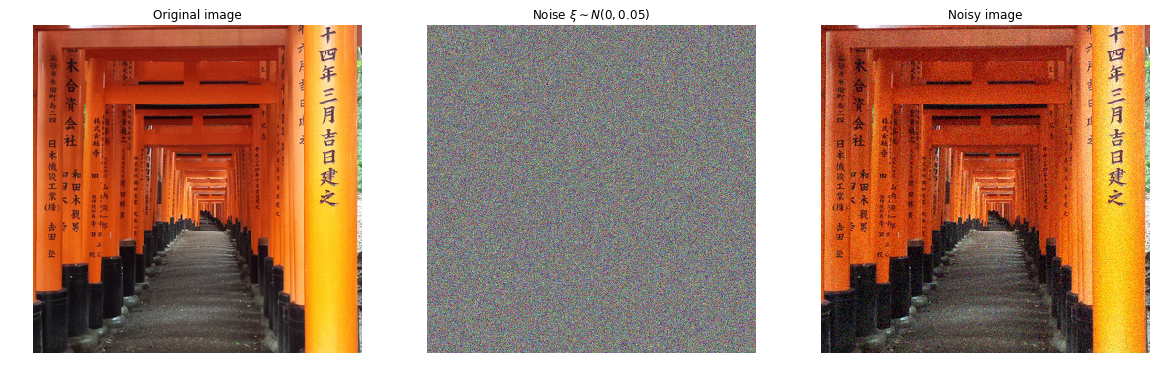

In [4]:
# Plot images
plt.figure(figsize=(20, 20))
# Show original image
plt.subplot(131)
plt.imshow(img)
plt.title('Original image')
_ = plt.axis('off')
# Show noise
plt.subplot(132)
plt.imshow((noise - noise.min())/(noise.max() - noise.min())) # Rescale noise for visualization
plt.title('Noise $\\xi\\sim N(0, %.2f)$' % sigma)
_ = plt.axis('off')
# Show noisy image
plt.subplot(133)
plt.imshow(noisy_img)
plt.title('Noisy image')
_ = plt.axis('off')

Now before we start the optimiation process we need to figure out a way to compute $\nabla u$ in the discrete setting. A common discretization is

\begin{split}
\left[\nabla u\right]_x(x, y)&=u(x+1, y)-u(x, y)\\
\left[\nabla u\right]_y(x, y)&=u(x , y+1)-u(x, y)\\
\end{split}

This can be implemented efficiently using 2d convolution. For this we'll need convolution kernels for the gradient along the x and y axes. In dynet, the relevant function is [`dy.conv2d`](http://dynet.readthedocs.io/en/latest/python_ref.html#dynet.conv2d). It requires the kernels to be provided with the folowing shape: `(width, height, num_channels, num_kernels)` (the last dimension is used when you have multiple kernels of the same shape e.g. in convolutional neural networks).

In [5]:
# The kernel for the gradient alongside the x axis is [1, -1] repeated along each channel, with shape (2, 1, 3, 1) 
nabla_x_values = np.repeat([1, -1], channels, axis=0).reshape((2, 1, channels, 1))
# The kernel for the gradient alongside the x axis is [1, -1] repeated along each channel, with shape (1, 2, 3, 1) 
nabla_y_values = np.repeat([1, -1], channels, axis=0).reshape((1, 2, channels, 1))

Now we can prepare for the optimization process by declaring our hyperparameters.

In [6]:
# Trade-off constant. High alpha means high fidelity. Low alpha means high smoothness
alpha = 1.0
# Number of iterations
n_iterations = 200
# Learning rate
initial_learning_rate=0.1

We define the parameters we're optimizing (the picture $u$), which is an image of the same shape as the original image. Notice that we initialize $u$ with the noisy image.

In [7]:
pc = dy.ParameterCollection()
u = pc.add_parameters(noisy_img.shape, init=noisy_img)

The last thing we need is the optimizer itself. I'll be using vanilla gradient descent, feel free to play around with momentum or [other optimizers](http://dynet.readthedocs.io/en/latest/python_ref.html#optimizers)

In [8]:
trainer = dy.SimpleSGDTrainer(pc, learning_rate=initial_learning_rate)

Now we're ready to run the optimization procedure. By now you should be familiar with the basic steps. If the process is taking too long consider reducing the number of iterations.

In [9]:
# Let's get started
for iteration in range(n_iterations):
    # Renew the computation graph
    dy.renew_cg()
    # Input the noisy image in the computation graph
    f_hat = dy.inputTensor(noisy_img)
    # Input the gradient kernels in the computation graph
    nabla_x = dy.inputTensor(nabla_x_values)
    nabla_y = dy.inputTensor(nabla_y_values)
    # Compute the gradient nabla_u with conv2d.
    # The "is_valid" argument tells dynet to pad u with 0s so that the output has the same shape as the input image
    nabla_u_x = dy.conv2d(u, nabla_x, stride=[1, 1], is_valid=False)
    nabla_u_y = dy.conv2d(u, nabla_y, stride=[1, 1], is_valid=False)
    # L2 norm of the gradient
    # First square each coordinate, add them, sum it along the channel dimension and then take the square root
    # I added a small constant in the square root to prevent NaN gradients when the gradient has norm 0
    nabla_u_2 = dy.sqrt(dy.sum_dim(dy.square(nabla_u_x) + dy.square(nabla_u_y), d=[2]) + 1e-20)
    # "Integrate" over the image by taking the sum
    E_smooth = dy.sum_elems(nabla_u_2)
    # Squared euclidean from f_hat at each pixel
    dist = dy.sum_dim(dy.square(f_hat - u), d=[2])
    # "Integrate" over the image by taking the sum
    E_fidelity = dy.sum_elems(dist)
    # Final objective
    E = E_smooth + alpha * E_fidelity
    # Forward pass
    objective_value = E.value() / (width * height)
    # Backward pass
    E.backward()
    # Update u
    trainer.update()
    # Print the current value of the objective every once in a while
    if (iteration+1) % (n_iterations // 10) ==0:
        print('Loss @%d%%: %.10f' % ((iteration+1) // (n_iterations // 10) * 10, objective_value))
# Retrieve denoised image (don't forget to clip the values)
denoised_img = np.clip(u.as_array(), 0, 1)

Loss @10%: 0.1361738492
Loss @20%: 0.0894965805
Loss @30%: 0.0729404327
Loss @40%: 0.0649391909
Loss @50%: 0.0598983953
Loss @60%: 0.0562808115
Loss @70%: 0.0535445790
Loss @80%: 0.0513755629
Loss @90%: 0.0495956157
Loss @100%: 0.0481033853


Let's see what we got

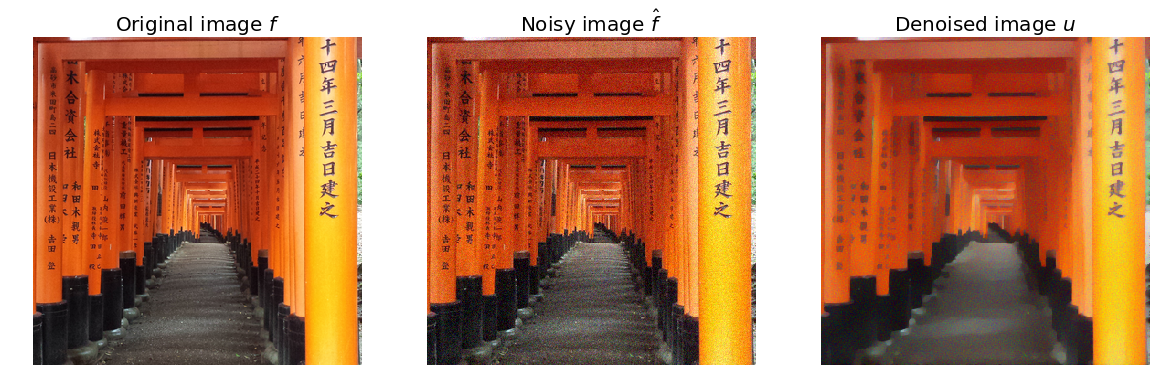

In [10]:
# Plot images
plt.figure(figsize=(20, 20))
# Show original image
plt.subplot(131)
plt.imshow(img)
plt.title('Original image $f$', fontsize=20)
_ = plt.axis('off')
# Show noise
plt.subplot(132)
plt.imshow(noisy_img)
plt.title('Noisy image $\hat f$', fontsize=20)
_ = plt.axis('off')
# Show noisy image
plt.subplot(133)
plt.imshow(denoised_img)
plt.title('Denoised image $u$', fontsize=20)
_ = plt.axis('off')

It's kind of hard to see here so let's plot the result on small subset of the image

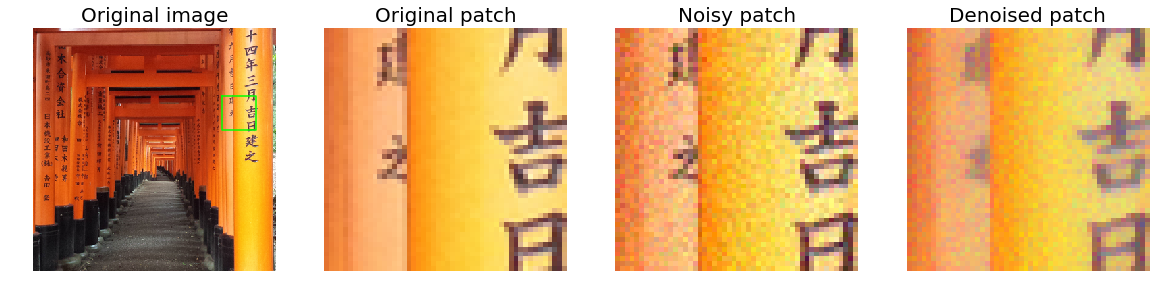

In [11]:
x1,x2 = 280, 330
y1,y2 = 100, 150
# Plot images
plt.figure(figsize=(20, 20))
# Show original image
plt.subplot(141)
plt.imshow(img)
# Add the delimiter for the patch we're visualizing
plt.plot([x1, x1, x2, x2, x1],[y1, y2, y2, y1, y1], color='lime')
plt.title('Original image', fontsize=20)
_ = plt.axis('off')
# Show patch in original image
plt.subplot(142)
plt.imshow(img[y1:y2, x1:x2])
plt.title('Original patch', fontsize=20)
_ = plt.axis('off')
# Show noise
plt.subplot(143)
plt.imshow(noisy_img[y1:y2, x1:x2])
plt.title('Noisy patch', fontsize=20)
_ = plt.axis('off')
# Show noisy image
plt.subplot(144)
denoised_patch=denoised_img[y1:y2, x1:x2]
plt.imshow(denoised_patch)
plt.title('Denoised patch', fontsize=20)
_ = plt.axis('off')